In [2]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import colormath
import seaborn as sns
import colour
import scipy.io
import numpy as np
import cv2

In [ ]:
model_name = 'CVAESPCA/'
root = '/work3/s212645/Spectral_Reconstruction/checkpoint/'
metrics = 'metrics.pth'
# modelname = 'net.pth'
path = root + model_name + metrics
result = torch.load(path, map_location=torch.device('cpu'))
# path = root + model_name + modelname
# model_dict = torch.load(path, map_location=torch.device('cpu'))
# print(model_dict['epoch'])

In [ ]:
MRAE = result['MRAE']
RMSE = result['RMSE']
PSNR = result['PSNR']
SAM = result['SAM']
# length = len(MRAE)
# for i in range(length):
#     MRAE[i] = MRAE[i].item()
# for i in range(length):
#     RMSE[i] = RMSE[i].item()
# for i in range(length):
#     PSNR[i] = PSNR[i].item()
# for i in range(length):
#     SAM[i] = SAM[i].item()
# print(length)

In [ ]:
length = 99
plt.figure(figsize=[20,5])
plt.suptitle("Spectral Normalization WGAN") 
plt.subplot(1, 4, 1)
plt.plot(range(length), MRAE[:length])
plt.title("MRAE")

plt.subplot(1, 4, 2)
plt.plot(range(length), RMSE[:length])
plt.title("RMSE")

plt.subplot(1, 4, 3)
plt.plot(range(length), PSNR[:length])
plt.title("PSNR")

plt.subplot(1, 4, 4)
plt.plot(range(length), SAM[:length])
plt.title("SAM")
filename = 'result/'+model_name.split('/')[0]+'.png'
plt.savefig(filename)

In [4]:
import os
import re
realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGAN/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/D2GANNZ/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGANNoNoise/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/MSTPlusPlus/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGANMST/'
fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/HSCNN_Plus/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/CVAESP/'

tail = re.compile('.dat')
f = os.listdir(fakeroot)
a = [(tail.search(file) != None) for file in f]
a.remove(False)
len(a)

6440

/tmp/ipykernel_15980/313172674.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,12,count)


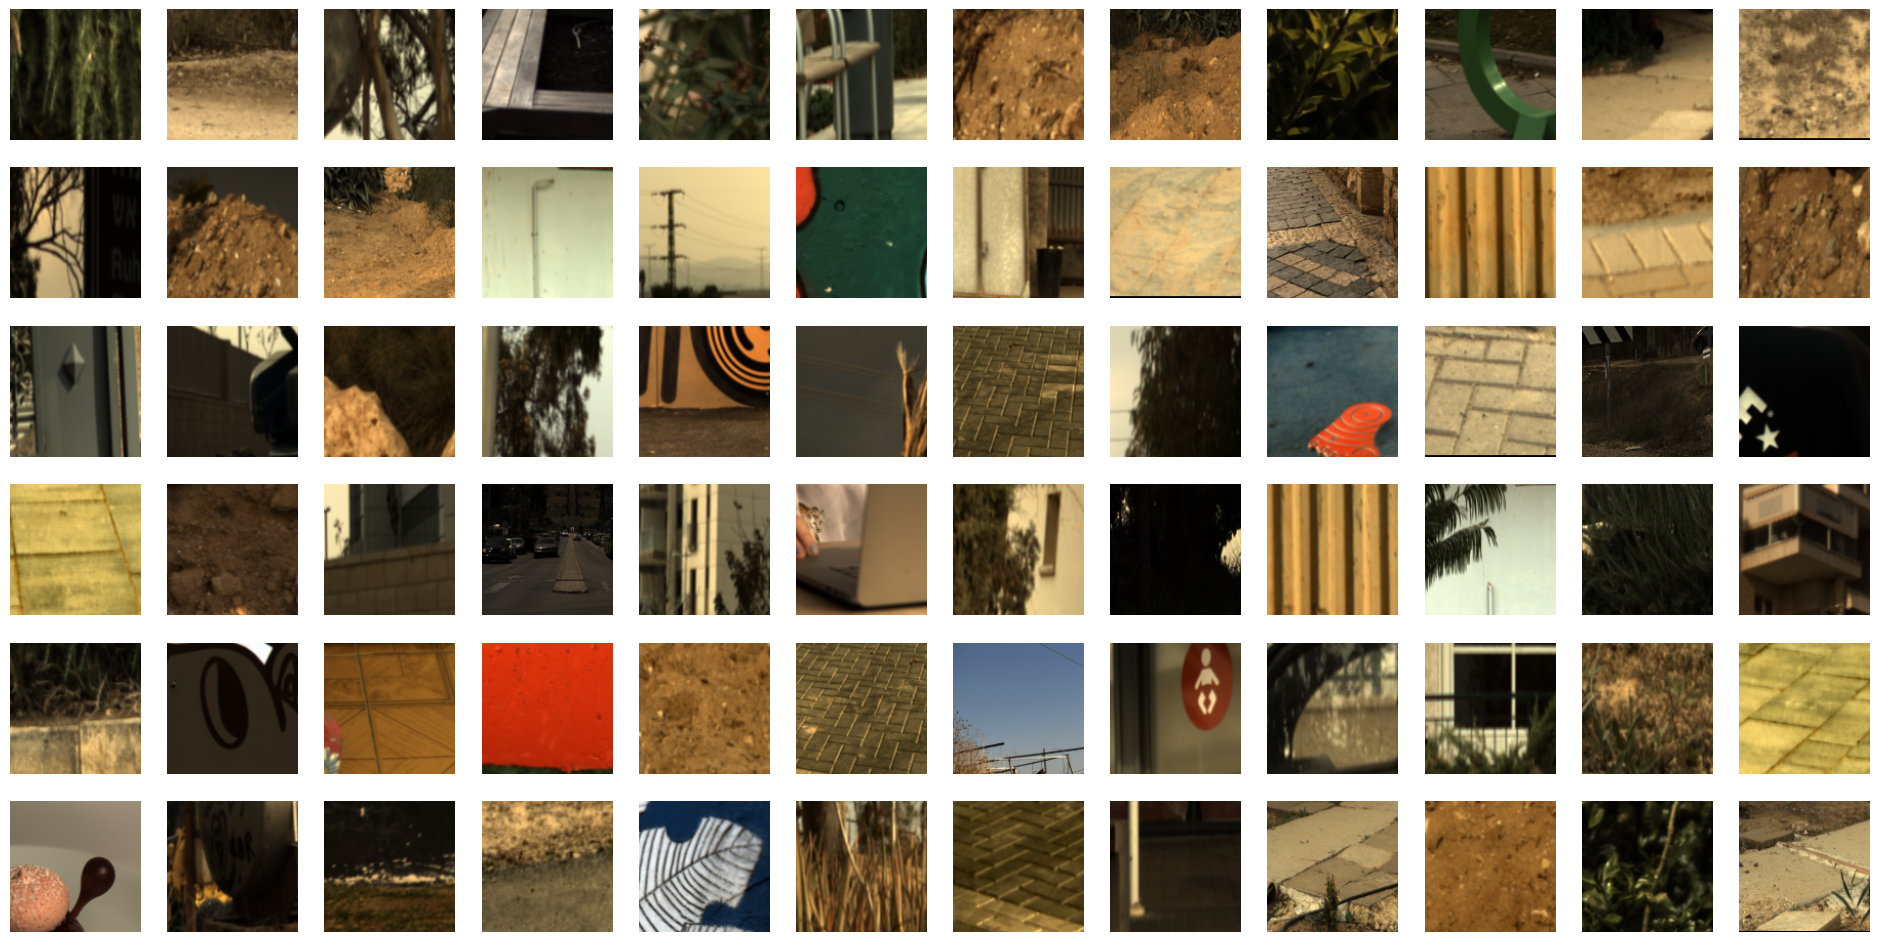

In [25]:
import random
# resultant random numbers list
randomList=[]
# traversing the loop 15 times
for i in range(100):
   # generating a random number in the range 1 to 100
   r=random.randint(1,6440)
   # checking whether the generated random number is not in the
   # randomList
   if r not in randomList:
        # appending the random number to the resultant list, if the condition is true
        randomList.append(r)

plt.figure(figsize=[24,12])
plt.title('RGB images')
count = 0
for k in randomList[:72]:
    num = str(k).zfill(3)
    name = num + '.mat'
    realrgb = scipy.io.loadmat(realroot + name)['rgb']
    realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())
    count += 1
    plt.subplot(6,12,count)
    plt.imshow(realrgb)
    plt.axis('off')


In [28]:
randomList[64]

5625

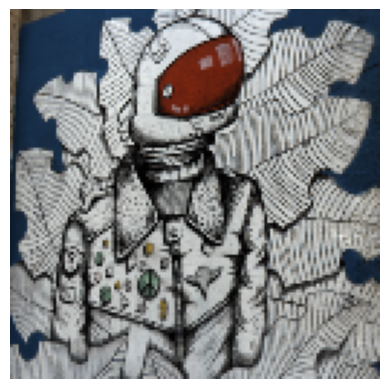

In [5]:
rgb = scipy.io.loadmat(realroot + '5642.mat')['rgb']
plt.imshow(rgb)
plt.axis('off')
# plt.title('RGB Image')
plt.show()

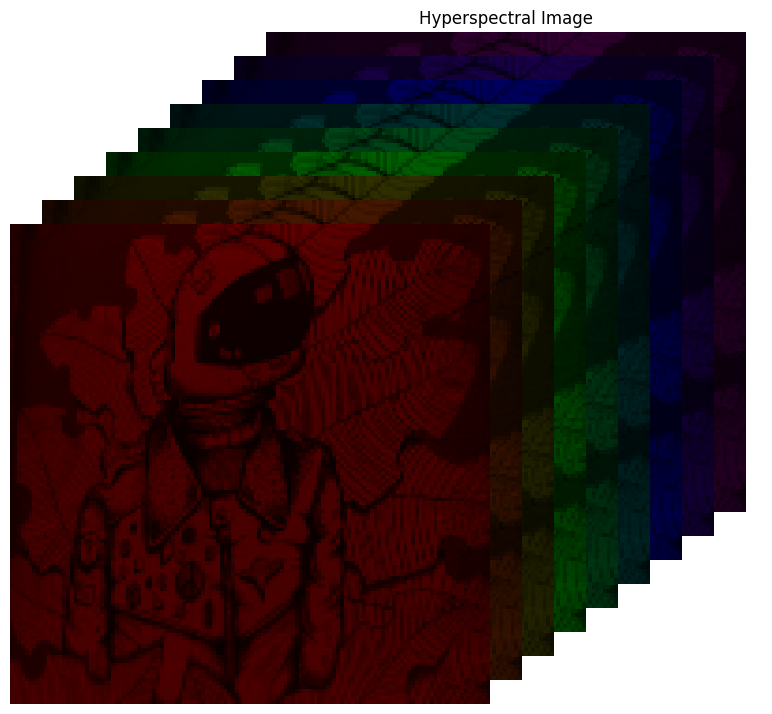

In [17]:
hyper = scipy.io.loadmat(realroot + '5642.mat')['cube']
image1 = hyper[:,:,0]
image2 = hyper[:,:,1]
image3 = hyper[:,:,2]
fig, ax = plt.subplots()
ax.axis('off')
images = []

for i in range(3):
    red_channel = image1 * (1 - i * 0.25)
    green_channel = image1 * i * 0.25
    blue_channel = image1 * 0
    image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    images.append(image)
for i in range(3):
    red_channel = image1 * 0
    green_channel = image1 * (1 - i * 0.25)
    blue_channel = image1 * i * 0.25
    image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    images.append(image)
for i in range(3):
    red_channel = image1 * i * 0.25
    green_channel = image1 * 0
    blue_channel = image1 * (1 - i * 0.25)
    image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    images.append(image)

for i in range(9):
    ax1 = fig.add_axes([-i * 0.05, -i * 0.05, 1, 1])  # [left, bottom, width, height]
    ax1.axis('off')
    ax1.imshow(images[8-i])
    if i == 0:
        plt.title('Hyperspectral Image')
plt.show()

In [ ]:
from utils import Loss_SSIM, Loss_PSNR, Loss_Fid, AverageMeter
# ssim = Loss_SSIM()
# losses_ssim = AverageMeter()

# fakergbs = []
# realrgbs = []
# # importing random module
# import random
# # resultant random numbers list
# randomList=[]
# # traversing the loop 15 times
# for i in range(15):
#    # generating a random number in the range 1 to 100
#    r=random.randint(1,6432)
#    # checking whether the generated random number is not in the
#    # randomList
#    if r not in randomList:
#       # appending the random number to the resultant list, if the condition is true
#       randomList.append(r)
# # printing the resultant random numbers list
# print("non-repeating random numbers are:")
randomList = [356, 381, 469, 543, 1518, 1706, 1860, 2790, 2821, 3460, 3604, 3657, 3697, 4455, 6322]
# randomList = [1,2,3,4,5]
print(randomList)
try:
   os.mkdir('result/Figures/')
except:
   pass
try:
   os.mkdir('result/Figures/ReconstructedRGB')
except:
   pass
try:
   os.mkdir('result/Figures/DeltaE')
except:
   pass
try:
   os.mkdir('result/Figures/MRAE')
except:
   pass
try:
   os.mkdir('result/Figures/SSIM')
except:
   pass
try:
   os.mkdir('result/Figures/SAM')
except:
   pass

for k in randomList:
    num = str(k).zfill(3)
    name = num + '.mat'

    fakergb = scipy.io.loadmat(fakeroot + name)['rgb']
    fakergb = (fakergb - fakergb.min()) / (fakergb.max()-fakergb.min())

    realrgb = scipy.io.loadmat(realroot + name)['rgb']
    realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())

    plt.figure(figsize=[12,6])
    plt.subplot(1, 2, 1)
    plt.imshow(realrgb)
    plt.title('Ground Truth')
    plt.subplot(1, 2, 2)
    plt.imshow(fakergb)
    plt.title('Fake Generation')
   #  plt.savefig('result/Figures/ReconstructedRGB/Reconstructed_RGB_image_{}.png'.format(num))
    

In [ ]:
deltaes = []
for k in range(6400):
    num = str(k).zfill(3)
    name = num + '.mat'
    fakergb = scipy.io.loadmat(fakeroot + name)['rgb']
    fakergb = (fakergb - fakergb.min()) / (fakergb.max()-fakergb.min())
    realrgb = scipy.io.loadmat(realroot + name)['rgb']
    realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())
    image1_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(realrgb))
    image2_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(fakergb))
    colour.delta_E(image1_lab, image2_lab).mean()
    deltae = colour.delta_E(image1_lab, image2_lab)
    deltaes.append(deltae.mean())
deltaes = np.array(deltaes)
error = deltaes.mean()

In [ ]:
for k in randomList:
    num = str(k).zfill(3)
    name = num + '.mat'

    fakergb = scipy.io.loadmat(fakeroot + name)['rgb']
    fakergb = (fakergb - fakergb.min()) / (fakergb.max()-fakergb.min())

    realrgb = scipy.io.loadmat(realroot + name)['rgb']
    realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())
    image1_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(realrgb))
    image2_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(fakergb))

    colour.delta_E(image1_lab, image2_lab, method="CIE 1976").mean()
    deltae = colour.delta_E(image1_lab, image2_lab, method="CIE 1976")
    sns.heatmap(deltae, cmap='jet')
    plt.savefig('result/Figures/DeltaE/Heatmap_{}.png'.format(num))
    plt.close()

In [ ]:
k = 6422
num = str(k)
name = num + '.mat'
fakergb = scipy.io.loadmat(fakeroot + name)['rgb']
fakergb = (fakergb - fakergb.min()) / (fakergb.max()-fakergb.min())
realrgb = scipy.io.loadmat(realroot + name)['rgb']
realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())
image1_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(realrgb))
image2_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(fakergb))
colour.delta_E(image1_lab, image2_lab, method="CIE 2000")
deltae = colour.delta_E(image1_lab, image2_lab, method="CIE 2000")
sns.heatmap(deltae, cmap='jet')
deltae.mean()

1. Spatial Disc and Spectral Disc 
2. Heat maps of {MRAE, SAM , deltaE_1976 or 2000}
3. Diffusion Model

In [ ]:
def MRAE(x,y):
    return (x-y) ** 2
fake = scipy.io.loadmat(fakeroot + name)['cube']
# fake = (fake - fake.min()) / (fake.max()-fake.min())
real = scipy.io.loadmat(realroot + name)['cube']
# real = (real - real.min()) / (real.max()-real.min())

In [ ]:
bands = np.linspace(400, 700, 31)
for k in randomList:
    num = str(k).zfill(3)
    name = num + '.mat'
    fake = scipy.io.loadmat(fakeroot + name)['cube']
    fake = (fake - fake.min()) / (fake.max()-fake.min())
    real = scipy.io.loadmat(realroot + name)['cube']
    real = (real - real.min()) / (real.max()-real.min())
    try:
        os.mkdir('result/Figures/MRAE/{}'.format(num))
    except:
        pass
    for i in range(31):
        band = bands[i]
        data = MRAE(real, fake)[:,:,i]
        # plt.subplot(6, 6, i+1)
        sns.heatmap(data, cmap='jet')
        plt.title('MRAE Hearmap Band: {}'.format(band))
        filename = 'result/Figures/MRAE/'+num+'/MRAEHeatmap_'+str(band)+'.png'
        plt.savefig(filename)
        plt.close()
    

for k in randomList:
    num = str(k).zfill(3)
    name = num + '.mat'
    fake = scipy.io.loadmat(fakeroot + name)['cube']
    fake = (fake - fake.min()) / (fake.max()-fake.min())
    real = scipy.io.loadmat(realroot + name)['cube']
    real = (real - real.min()) / (real.max()-real.min())
    data = MRAE(real, fake).mean(axis=2)
    sns.heatmap(data, cmap='jet')
    filename = 'result/Figures/MRAE/Heatmap_{}.png'.format(num)
    plt.savefig(filename)
    plt.close()

In [ ]:
def SAMHeatMap(preds, target):
    dot_product = np.sum(preds * target, axis=2)
    preds_norm = np.linalg.norm(preds, axis=2)
    target_norm = np.linalg.norm(target, axis=2)
    sam_score = np.arccos(dot_product / (preds_norm * target_norm))
    return sam_score

for k in randomList:
    num = str(k).zfill(3)
    name = num + '.mat'
    fake = scipy.io.loadmat(fakeroot + name)['cube']
    fake = (fake - fake.min()) / (fake.max()-fake.min())
    real = scipy.io.loadmat(realroot + name)['cube']
    real = (real - real.min()) / (real.max()-real.min())
    sam = SAMHeatMap(real, fake)
    sns.heatmap(sam, cmap='jet')
    plt.savefig('result/Figures/SAM/Heatmap_{}.png'.format(num))
    plt.close()

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
for k in randomList:
    num = str(k).zfill(3)
    name = num + '.mat'

    fakergb = scipy.io.loadmat(fakeroot + name)['rgb']
    fakergb = (fakergb - fakergb.min()) / (fakergb.max()-fakergb.min())

    realrgb = scipy.io.loadmat(realroot + name)['rgb']
    realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())
    
    ssim = StructuralSimilarityIndexMeasure(return_full_image=True)(torch.from_numpy(fakergb.transpose(2,0,1)).unsqueeze(dim=0), torch.from_numpy(realrgb.transpose(2,0,1)).unsqueeze(dim=0))[1].squeeze(dim=0).mean(dim=0).numpy()
    sns.heatmap(ssim, cmap='jet_r')
    plt.savefig('result/Figures/SSIM/Heatmap_{}.png'.format(num))
    plt.close()

YCbCr Color space Y channel for SSIM and PSNR

Grey image for SSIM and PSNR

Generate results: heatmap, convergence resultes

In [ ]:
from torchview import draw_graph
from Models.GAN.networks import DenseLayer, DenseBlock, DensenetGenerator
from Models.Transformer.DTN import DTN, Adaptive_MSAB, Adaptive_SWTB, DTNBlock, SWTB, MSAB
from Models.Transformer.MST_Plus_Plus import MS_MSA
from Models.Transformer.swin_transformer import SwinTransformerBlock

In [ ]:
model = DensenetGenerator(inchannels = 34, 
                 outchannels =31, 
                 num_init_features = 64, 
                 block_config = (6, 12, 24, 16), 
                 bn_size = 4, 
                 growth_rate = 32, 
                 center_layer = 6)

model_graph = draw_graph(model, input_size=(1, 34, 128, 128), device='meta')
model_graph.visual_graph

In [ ]:
model = DTN(in_dim=3, 
            out_dim=31,
            img_size=[128, 128], 
            window_size=8, 
            n_block=[2,2,2,2], 
            bottleblock = 4)

model_graph = draw_graph(model, input_size=(1, 3, 128, 128), device='meta', depth=1, graph_dir='TB', show_shapes=False, save_graph=True, filename='DTNstructure.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = SWTB(dim=31, input_resolution=(128, 128), num_heads=1, window_size=8)
model_graph = draw_graph(model, input_size=(1, 31, 128, 128), device='meta', depth=1, graph_dir='LR', show_shapes=False, save_graph=True, filename='SWTB.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = SwinTransformerBlock(dim=31, input_resolution=(128, 128), num_heads=1, window_size=8)
model_graph = draw_graph(model, input_size=(1, 128*128, 31), device='meta', depth=1, graph_dir='TB', show_shapes=False, save_graph=True, filename='SwinTransformerBlock.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = MSAB(dim = 31,
            dim_head =31,
            heads = 1,
            num_blocks = 1)
model_graph = draw_graph(model, input_size=(1, 31, 128, 128), device='meta', depth=1, graph_dir='LR', show_shapes=False, save_graph=True, filename='MSAB.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = MS_MSA(dim = 31,
            dim_head =31,
            heads = 1)
model_graph = draw_graph(model, input_size=(1, 128, 128, 31), device='meta', depth=1, graph_dir='LR', show_shapes=False, save_graph=True, filename='MS_MSA.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = Adaptive_MSAB(dim = 31,
            dim_head =31,
            heads = 1,
            num_blocks = 1)
model_graph = draw_graph(model, input_size=(1, 31, 128, 128), device='meta', depth=1, graph_dir='LR', show_shapes=False, save_graph=True, filename='Adaptive_MSAB.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = Adaptive_SWTB(dim=31, input_resolution=(128, 128), num_heads=1, window_size=8)
model_graph = draw_graph(model, input_size=(1, 31, 128, 128), device='meta', depth=1, graph_dir='LR', show_shapes=False, save_graph=True, filename='Adaptive_SWTB.png', directory='model_structures/')
model_graph.visual_graph

In [ ]:
model = DTNBlock(dim=31, dim_head=31, input_resolution=(128, 128), num_heads=1, window_size=8, num_block=1)
model_graph = draw_graph(model, input_size=(1, 31, 128, 128), device='meta', depth=2, graph_dir='LR', show_shapes=False, save_graph=True, filename='DTNBlock.png', directory='model_structures/')
model_graph.visual_graph